<a href="https://colab.research.google.com/github/Hurri301/Advanced-Computational-Techniques-for-Big-Imaging-and-Signal-Data/blob/main/ECG_project_Horia_Ameen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Readme File


**Usage**
To train and evaluate the models, follow the instructions in the Jupyter notebooks provided in the notebooks directory. Each notebook corresponds to a specific model or step in the pipeline.

To deploy the trained models or use them for inference, refer to the instructions in the deployment section of the documentation.

**Dataset**
The dataset used in this project is the MIT-BIH Arrhythmia Database, which contains labeled ECG recordings of various arrhythmias. Please download the dataset and place it in the data directory before running the notebooks.

**Models**
The project includes the implementation of several machine learning and deep learning models for arrhythmia detection, including:

Support Vector Machine with K-fold cross validation
Feed Forward Neural Network
Each model is implemented and evaluated separately in the corresponding Jupyter notebooks.

**Evaluation**
The performance of each model is evaluated using metrics such as accuracy, precision, recall, and F1-score. The evaluation results are presented in the respective notebooks and summarized in the final report.

**Contributing**
Contributions to this project are welcome! To contribute, please follow these steps:

Fork the repository
Create your feature branch (git checkout -b feature-branch)
Commit your changes (git commit -am 'Add new feature')
Push to the branch (git push origin feature-branch)
Create a new Pull Request
Please ensure that your contributions adhere to the project's coding standards and guidelines.

License **bold text**
This project is licensed under the MIT License. See the LICENSE file for details.

**Contact**
For questions, feedback, or collaboration opportunities, please contact:

Horia Ameen

Email: h.ameen@campus.unimib.it
LinkedIn: linkedin.com/in/horia-ameen-683b451a8/

# Data PreProcessing

#### Import Libararies

In [4]:
######## Import libraries ########
import random
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import randint

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

#### Data Loading

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
base_path = '/content/drive/My Drive/Advance_Comp/MIT-BIH.csv'
file_name = 'MIT-BIH.csv'
random_seed = 42

In [7]:
df = pd.read_csv(base_path).drop('Unnamed: 0', axis=1)
print(df.shape)
df.head(2)

(107775, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,target
0,0.006723,-0.019156,0.032603,0.006723,0.084363,0.032603,0.032603,0.006723,0.006723,0.084363,...,-0.536756,-0.562636,-0.614396,-0.588516,-0.666156,-0.640276,-0.640276,-0.588516,-0.640276,1
1,-0.122676,-0.200316,-0.200316,-0.252076,-0.226196,-0.174436,-0.122676,-0.174436,-0.174436,-0.174436,...,-0.562636,-0.510876,-0.510876,-0.536756,-0.562636,-0.588516,-0.588516,-0.614396,-0.562636,1


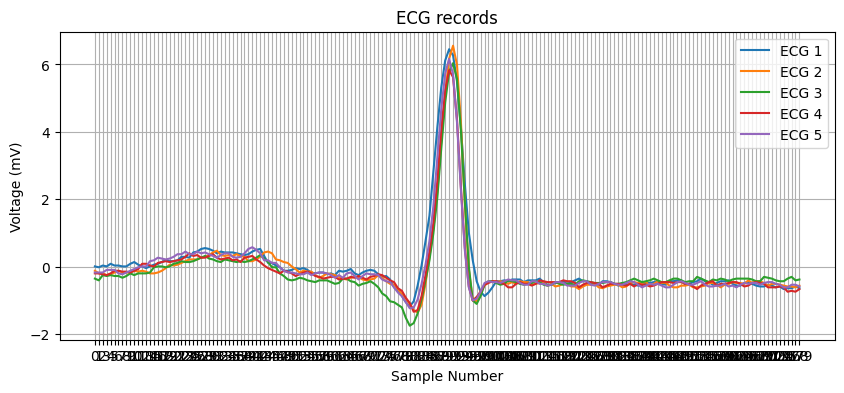

In [8]:
# Plot the first 5 rows as an example
# Modify these column names according to your dataset
# Drop the 'target' column for the signal data
signal_data = df.drop(columns=['target'])
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(signal_data.iloc[i, :], label=f'ECG {i+1}')

plt.title('ECG records')
plt.xlabel('Sample Number')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
## Class Distribution
print(df['target'].value_counts(),'\n')
# df_raw.hist(column='label', bins=15, grid=True, figsize=(6,4))

target
1    89694
2     8001
4     6487
3     2814
0      779
Name: count, dtype: int64 



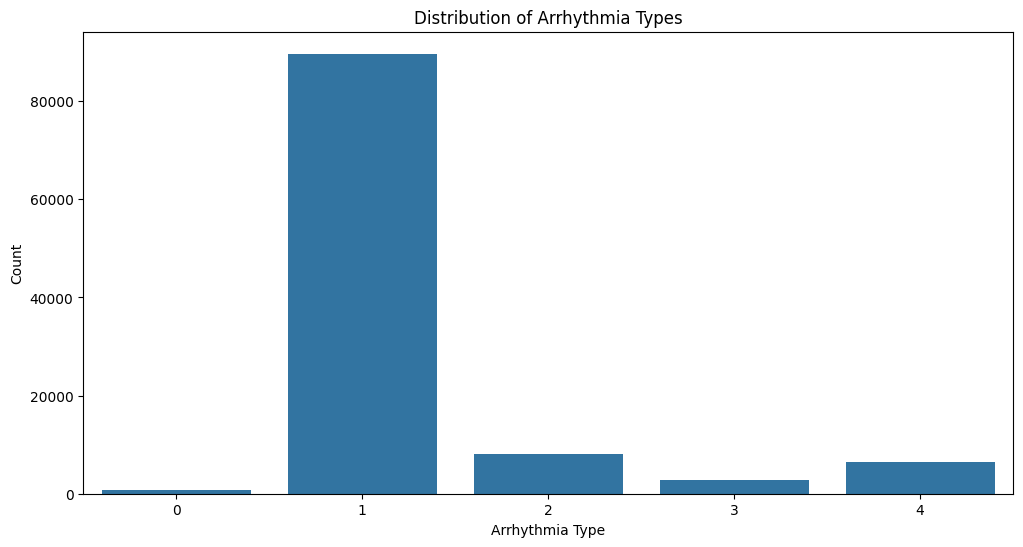

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
# Visualizing the distribution of each type of arrhythmia
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=df)
plt.title('Distribution of Arrhythmia Types')
plt.xlabel('Arrhythmia Type')
plt.ylabel('Count')
plt.show()

In [11]:
df.rename(columns={'target': 'y'}, inplace=True)
print(df.shape)
df.head(2)

(107775, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,y
0,0.006723,-0.019156,0.032603,0.006723,0.084363,0.032603,0.032603,0.006723,0.006723,0.084363,...,-0.536756,-0.562636,-0.614396,-0.588516,-0.666156,-0.640276,-0.640276,-0.588516,-0.640276,1
1,-0.122676,-0.200316,-0.200316,-0.252076,-0.226196,-0.174436,-0.122676,-0.174436,-0.174436,-0.174436,...,-0.562636,-0.510876,-0.510876,-0.536756,-0.562636,-0.588516,-0.588516,-0.614396,-0.562636,1


In [12]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
176    float64
177    float64
178    float64
179    float64
y        int64
Length: 181, dtype: object

In [13]:
### Shuffle the DataFrame samples (rows)
df = df.sample( frac = 1 ).reset_index( drop = True )
print(df.shape)
df.head(2)

(107775, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,y
0,0.213763,0.265523,0.213763,0.213763,0.187883,0.187883,0.213763,0.317283,0.291403,0.239643,...,-0.200316,-0.252076,-0.277956,-0.226196,-0.226196,-0.200316,-0.303836,-0.355596,-0.329716,1
1,-0.755919,-0.814284,-0.901830,-0.843466,-0.843466,-0.901830,-0.872648,-1.047742,-1.106107,-1.106107,...,-0.113908,0.061186,0.090368,0.119551,0.148733,0.177915,0.236280,0.294645,0.382192,1


#### Normalization

In [14]:
import pandas as pd

def normalization_func(df_, method):
    x = df_.drop('y', axis=1)
    y = df_['y']

    if method == 'linear_norm':  # Linear Normalization: (x - x_min) / (x_max - x_min)
        df_linear_norm = (x - x.min()) / (x.max() - x.min())
        df_linear_norm['y'] = y
        return df_linear_norm
    elif method == 'z_score':  # Z-score (Standardization): (x - x_mean) / x_std
        df_z_score_norm = (x - x.mean()) / x.std()
        df_z_score_norm['y'] = y
        return df_z_score_norm

# Assuming df is already defined and loaded
df_norm = normalization_func(df, 'linear_norm').sample(frac=1).reset_index(drop=True)
print(df_norm.shape)
df_norm.head(2)

(107775, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,y
0,0.520405,0.526864,0.523670,0.519865,0.517617,0.510391,0.508530,0.508909,0.506956,0.509773,...,0.467338,0.476081,0.481996,0.484566,0.480239,0.476895,0.477356,0.481698,0.477061,1
1,0.520928,0.522149,0.525377,0.523295,0.519756,0.517284,0.520118,0.523029,0.523613,0.521019,...,0.471641,0.474447,0.479654,0.479635,0.477905,0.476201,0.477450,0.480144,0.476786,2


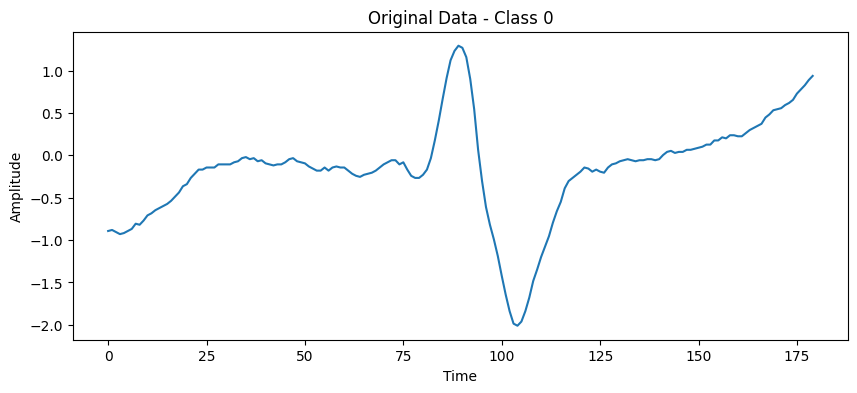

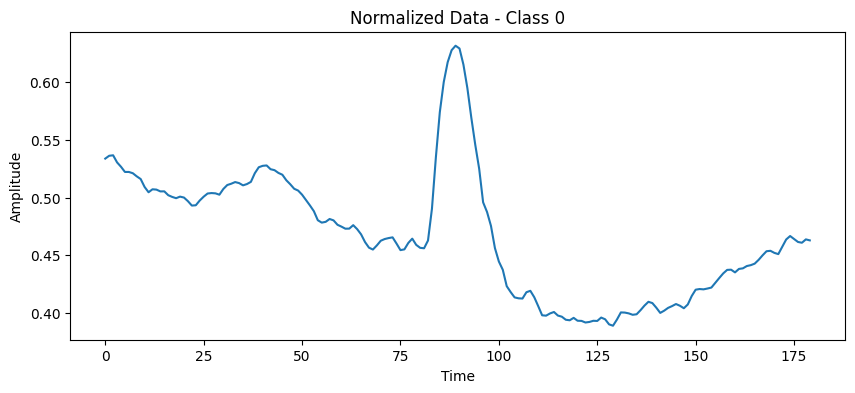

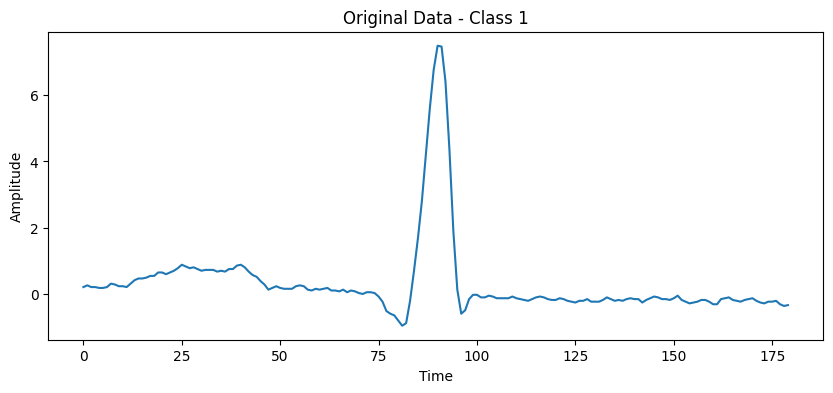

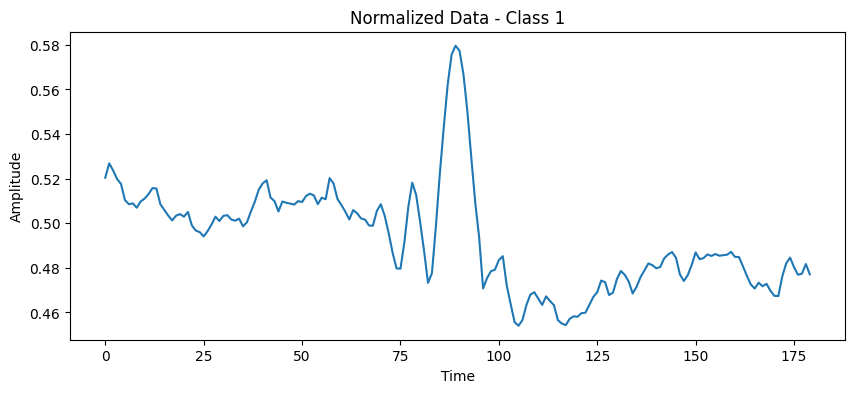

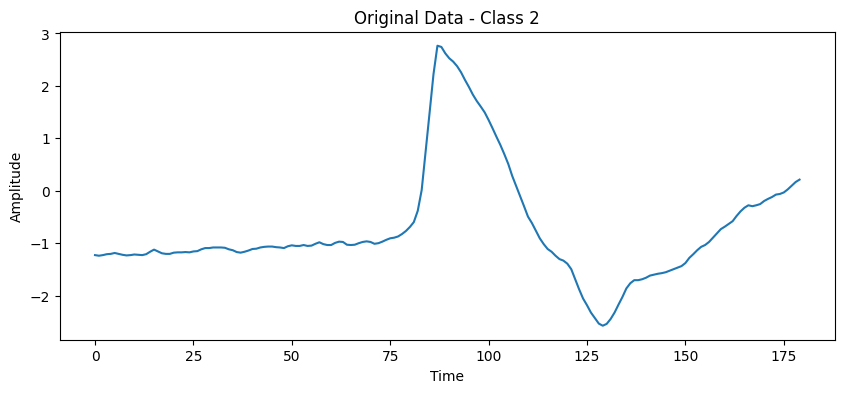

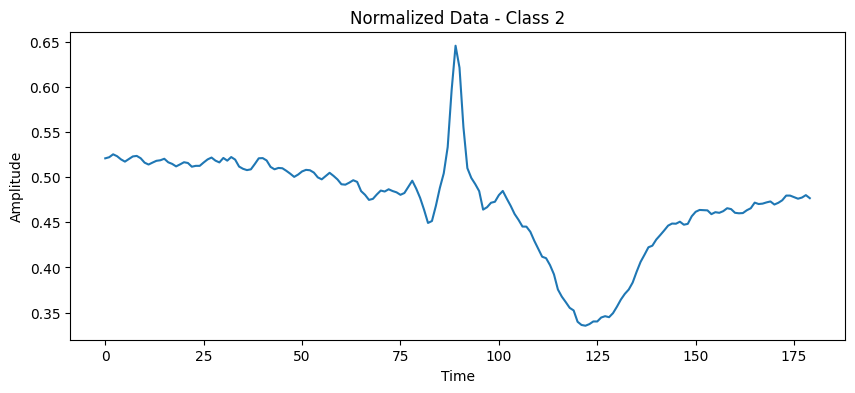

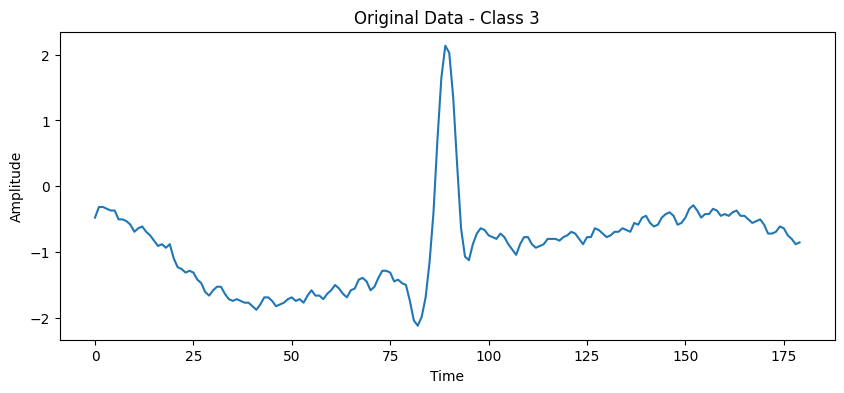

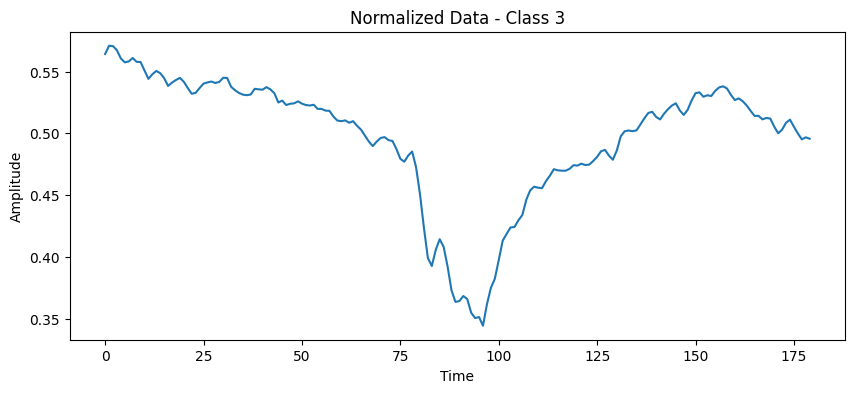

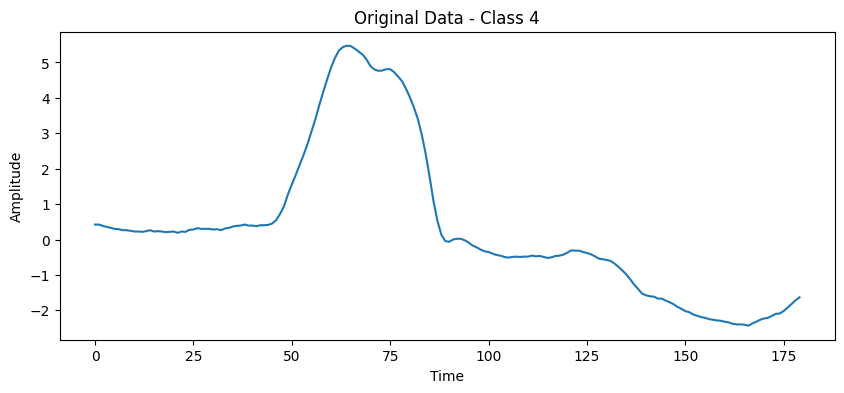

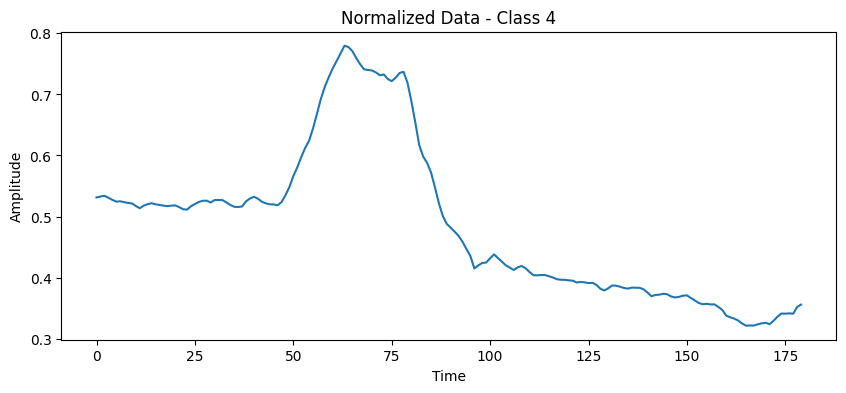

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Let's define a plotting function
def plotting_func(df, class_, title, index_):
    class_data = df[df['y'] == class_].drop('y', axis=1).iloc[index_]
    plt.figure(figsize=(10, 4))
    plt.plot(class_data.values)
    plt.title(f'{title} - Class {class_}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

# Assuming df and df_norm are already defined and contain the original and normalized data respectively
classes = [0, 1, 2, 3, 4]

for class_ in classes:
    # Plot original data
    plotting_func(df, class_, 'Original Data', 0)
    # Plot normalized data
    plotting_func(df_norm, class_, 'Normalized Data', 0)

#### Outlier Detection

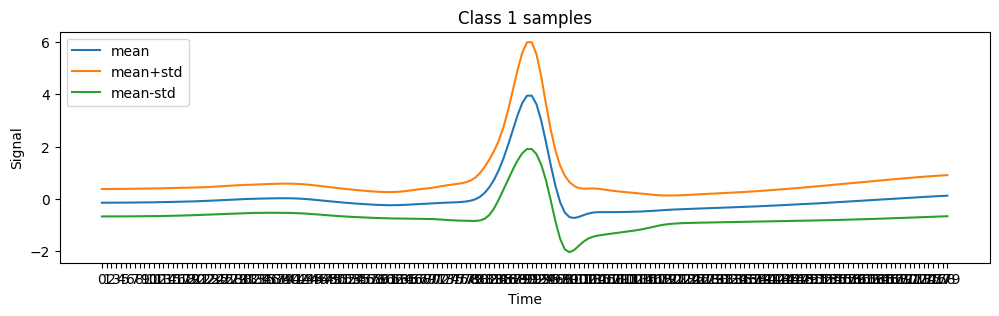

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_1_thre_50 --- (79645, 181)


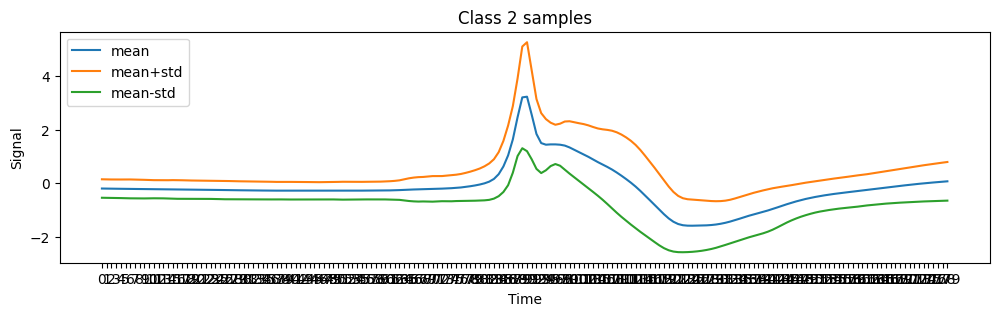

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_2_thre_50 --- (6722, 181)


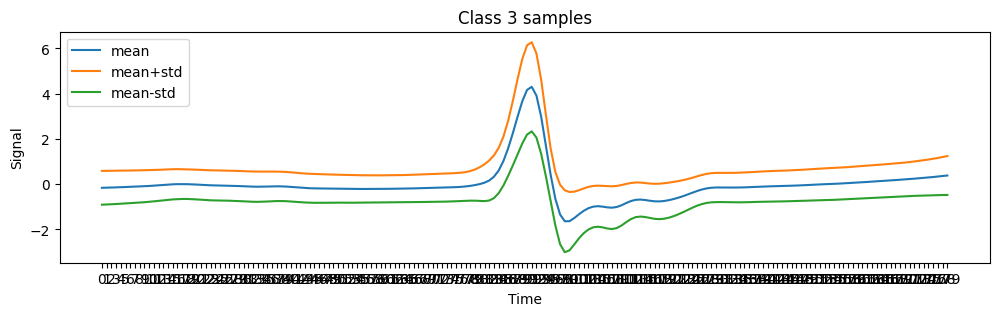

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_3_thre_50 --- (2216, 181)


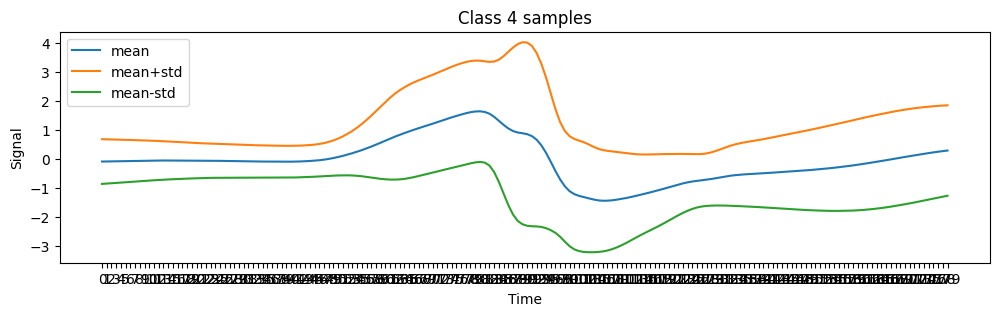

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_4_thre_50 --- (5983, 181)


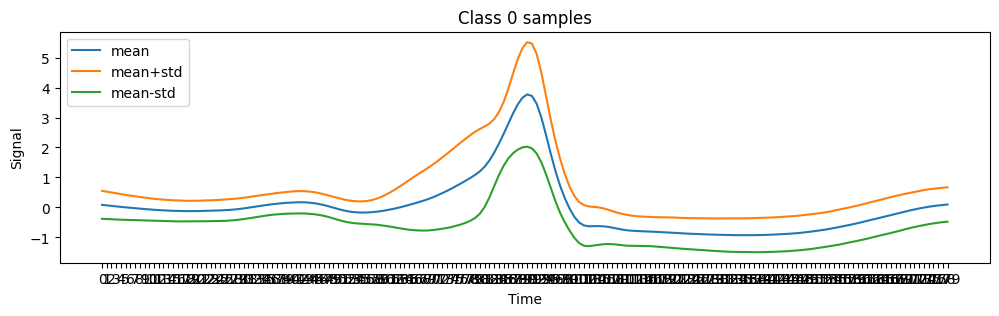

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_0_thre_50 --- (649, 181)
shape of data without outliers --- 95215


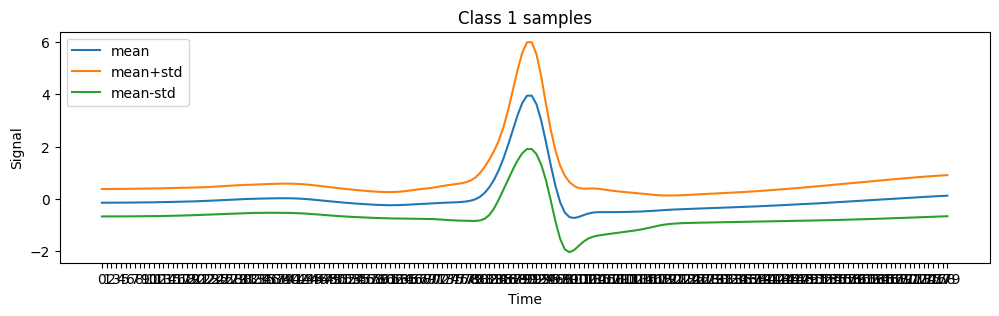

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_1_thre_60 --- (74568, 181)


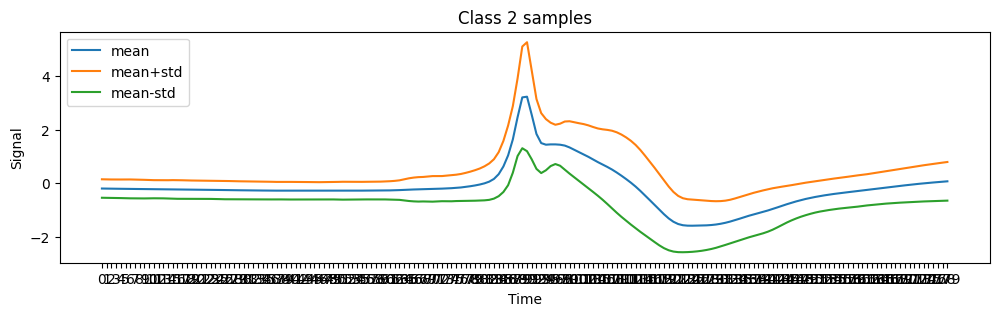

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_2_thre_60 --- (6243, 181)


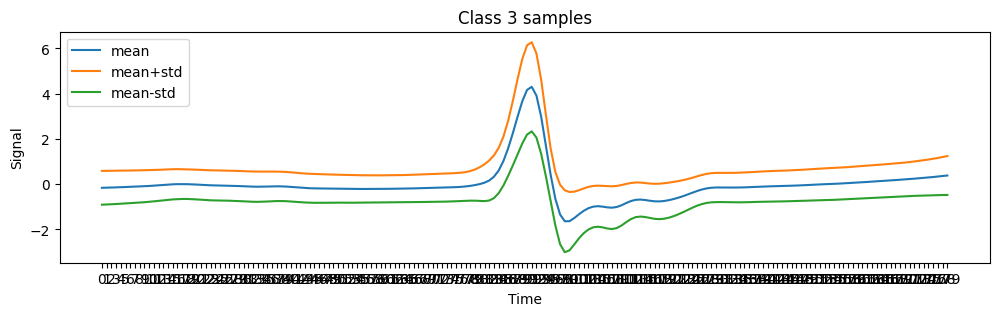

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_3_thre_60 --- (2020, 181)


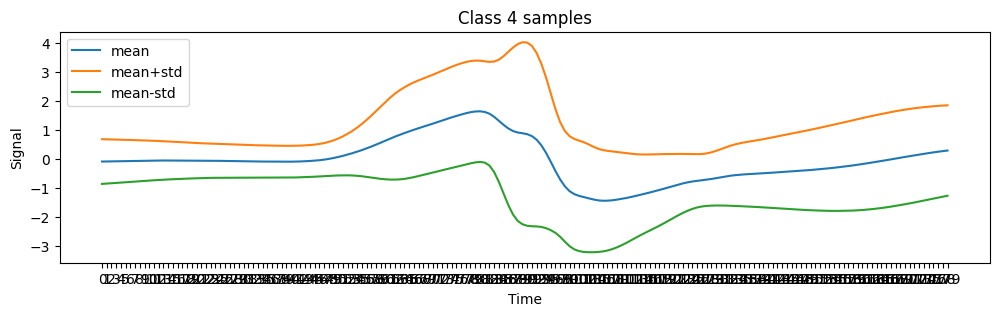

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_4_thre_60 --- (4809, 181)


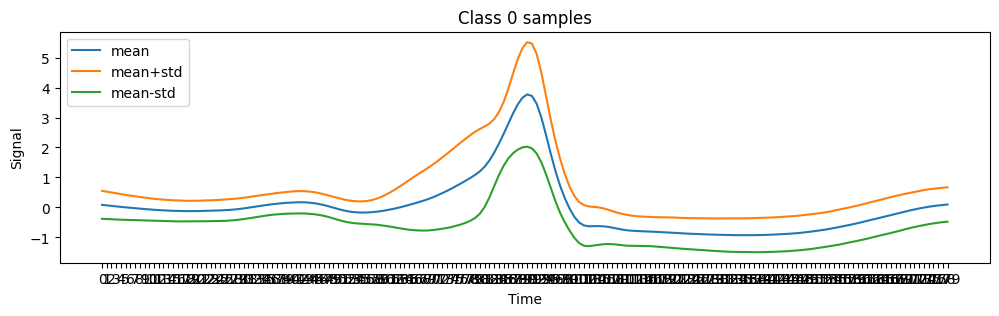

<ipython-input-16-aa1519b34e21>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['y'] = i


class_0_thre_60 --- (599, 181)
shape of data without outliers --- 88239


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def outlier_detection(df_o, outlier_threshold=50):
    target_classes = df_o['y'].unique()
    dict_without_outliers = {}
    dataset_count = 0

    for i in target_classes:
        df_ = df_o[df_o['y'] == i].drop('y', axis=1)
        df_mean = df_.mean()
        df_std = df_.std()
        df_upper_bound = df_mean + df_std
        df_lower_bound = df_mean - df_std

        # plotting the graphs
        plt.figure(figsize=(12, 3))
        plt.plot(df_mean, label="mean")
        plt.plot(df_mean + df_std, label="mean+std")
        plt.plot(df_mean - df_std, label="mean-std")

        plt.legend(loc="upper left")
        plt.xlabel('Time')
        plt.ylabel('Signal')
        plt.title(f'Class {i} samples')
        plt.show()

        # check the outliers, True --- not outlier, False --- Outlier
        df_boolean = df_.apply(lambda x: (x >= df_lower_bound) & (x <= df_upper_bound), axis=1)

        # Apply boolean indexing and replace the outliers with NaN values
        result_df = df_.mask(df_boolean == False)

        # drop values with threshold
        threshold_ = len(result_df.columns) * (outlier_threshold / 100)  # must have at least x non-missing values
        df_filtered = result_df.dropna(thresh=threshold_)

        # Fill na values with the median value
        df_final = df_filtered.fillna(df_filtered.median())

        # add class column
        df_final['y'] = i

        df_name = 'class_' + str(i) + '_thre_' + str(outlier_threshold)
        dict_without_outliers[df_name] = df_final

        print(f'{df_name} --- {df_final.shape}')
        dataset_count += df_final.shape[0]

    # Concatenate DataFrames stored in the dictionary vertically
    df_without_outliers = pd.concat([_df_ for _df_ in dict_without_outliers.values()], axis=0)
    print(f'shape of data without outliers --- {dataset_count}')
    return df_without_outliers

# Now you can call the function
df_without_outliers_50 = outlier_detection(df, 50)
df_without_outliers_60 = outlier_detection(df, 60)

In [17]:
######### Normalize df_without_outliers_50 and df_without_outliers_60
df_without_outliers_50_norm = normalization_func( df_without_outliers_50, 'linear_norm' ).sample(frac=1).reset_index(drop=True).sample( frac = 1 ).reset_index( drop = True )
df_without_outliers_60_norm = normalization_func( df_without_outliers_60, 'linear_norm' ).sample(frac=1).reset_index(drop=True).sample( frac = 1 ).reset_index( drop = True )
print(f'df_without_outliers_50_norm ----- {df_without_outliers_50_norm.shape}')
print(f'df_without_outliers_60_norm ----- {df_without_outliers_60_norm.shape}')

<ipython-input-14-c0bb8410eb05>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_linear_norm['y'] = y
<ipython-input-14-c0bb8410eb05>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_linear_norm['y'] = y


df_without_outliers_50_norm ----- (95215, 181)
df_without_outliers_60_norm ----- (88239, 181)


#### Feature Selection (PCA)

In [18]:
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.metrics

In [19]:
def plot_pca_data( df, df_pca, index):
  plt.figure( figsize = (10, 4) )
  plt.plot( range(df.iloc[0].shape[0]), df.iloc[index],     label = 'original data' ) ## original data
  plt.plot( range(df.iloc[0].shape[0]), df_pca.iloc[index], label = 'inverted data' ) ## inverted data
  # plt.ylim(0,2)
  plt.legend()
  plt.show()

In [20]:
def pca_func( df, n_comp ): ## PCA
  pca = sklearn.decomposition.PCA( n_components = n_comp ) ## n_component = how much info you want to keep after transformation
  x_pca = pca.fit_transform( df )
  # print(x_pca.shape)

  inv_pca = pca.inverse_transform(x_pca) ## inverse
  # print(inv_pca.shape)
  return inv_pca

In [21]:
x = df.drop('y', axis=1)
print(x.shape)
y = df['y']

(107775, 180)


In [22]:
df_pca =  pd.DataFrame( pca_func( x, 0.99 ), columns= df.columns[:-1] )
print(df_pca.shape)
df_pca.head(2)

(107775, 180)


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.147899,0.155853,0.165822,0.176949,0.190002,0.202978,0.219622,0.239023,0.261426,0.285441,...,-0.234422,-0.234750,-0.238059,-0.240449,-0.241933,-0.240866,-0.238808,-0.236693,-0.234027,-0.228766
1,-0.869023,-0.871792,-0.875963,-0.876160,-0.872816,-0.867905,-0.863465,-0.868089,-0.878468,-0.890896,...,-0.030542,0.005116,0.045711,0.089312,0.127739,0.157595,0.179148,0.195362,0.211685,0.223909


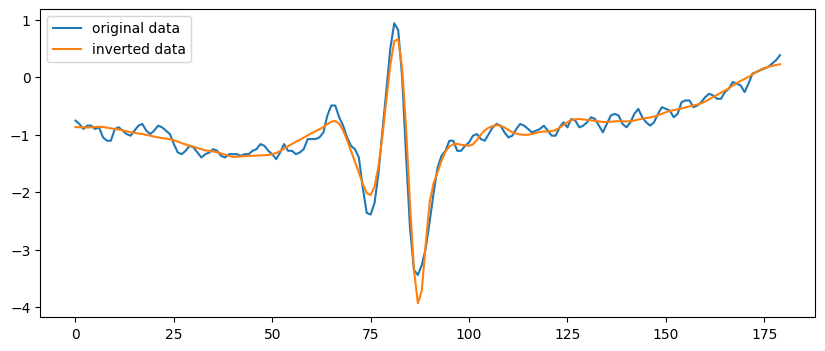

In [23]:
## Plot original and pca transformed data
index = 1
plot_pca_data( x, df_pca, index)

In [24]:
df_pca['y'] = y
print(df_pca.shape)
df_pca.head(2)

(107775, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,y
0,0.147899,0.155853,0.165822,0.176949,0.190002,0.202978,0.219622,0.239023,0.261426,0.285441,...,-0.234750,-0.238059,-0.240449,-0.241933,-0.240866,-0.238808,-0.236693,-0.234027,-0.228766,1
1,-0.869023,-0.871792,-0.875963,-0.876160,-0.872816,-0.867905,-0.863465,-0.868089,-0.878468,-0.890896,...,0.005116,0.045711,0.089312,0.127739,0.157595,0.179148,0.195362,0.211685,0.223909,1


In [25]:
######### Normalization of the pca df
df_pca_norm = normalization_func( df_pca, 'linear_norm' ).sample( frac = 1 ).reset_index( drop = True )
print(df_pca_norm.shape)
df_pca_norm.head(2)

(107775, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,y
0,0.525263,0.525330,0.525623,0.525990,0.526447,0.526896,0.527272,0.527694,0.528166,0.528770,...,0.444605,0.445801,0.447049,0.448287,0.449659,0.451189,0.452803,0.454446,0.456131,1
1,0.500232,0.500297,0.500436,0.500615,0.500892,0.501242,0.501640,0.502143,0.502725,0.503445,...,0.398921,0.398575,0.398306,0.397985,0.397705,0.397520,0.397375,0.397346,0.397501,1


#### Class Balancing

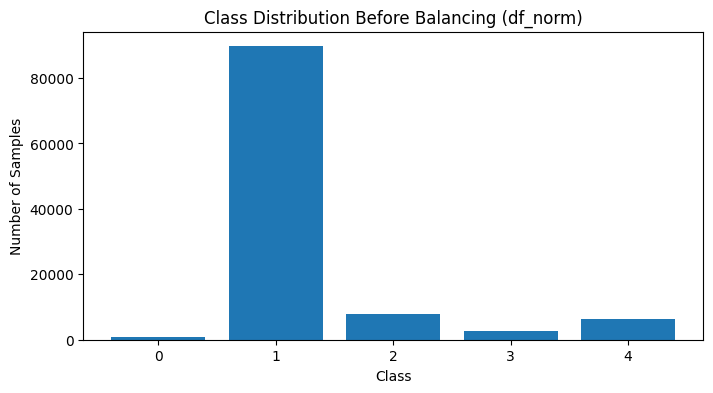

Class 1 samples: 779
Class 2 samples: 779
Class 4 samples: 779
Class 3 samples: 779
Class 0 samples: 779
Class 1 samples: 649
Class 2 samples: 649
Class 4 samples: 649
Class 3 samples: 649
Class 0 samples: 649
Class 1 samples: 599
Class 2 samples: 599
Class 4 samples: 599
Class 3 samples: 599
Class 0 samples: 599
Class 1 samples: 779
Class 2 samples: 779
Class 4 samples: 779
Class 3 samples: 779
Class 0 samples: 779


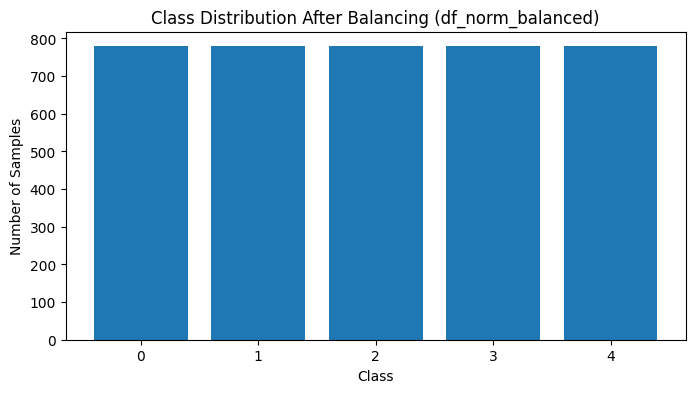

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_distribution(df, title):
    class_counts = df['y'].value_counts()
    plt.figure(figsize=(8, 4))
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.show()

def undersampling_func(df):
    class_counts = df['y'].value_counts()
    min_class = class_counts.idxmin()
    min_count = class_counts.min()

    # Creating a balanced dataset by undersampling
    df_balanced = pd.concat([
        df[df['y'] == cls].sample(n=min_count, random_state=42)
        for cls in class_counts.index
    ])

    # Shuffle the balanced dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    for cls in class_counts.index:
        print(f'Class {cls} samples: {df_balanced[df_balanced["y"] == cls].shape[0]}')

    return df_balanced

# Load your dataset
# file_path = 'path_to_your_csv_file.csv'  # replace with your file path
# df = pd.read_csv(file_path)

# Assuming df_norm, df_without_outliers_50_norm, df_without_outliers_60_norm, df_pca_norm are already defined

# Plot class distribution before balancing
plot_class_distribution(df_norm, 'Class Distribution Before Balancing (df_norm)')

# Applying the undersampling function to your datasets
df_norm_balanced = undersampling_func(df_norm)
df_without_outliers_50_norm_balanced = undersampling_func(df_without_outliers_50_norm)
df_without_outliers_60_norm_balanced = undersampling_func(df_without_outliers_60_norm)
df_pca_norm_balanced = undersampling_func(df_pca_norm)

# Plot class distribution after balancing
plot_class_distribution(df_norm_balanced, 'Class Distribution After Balancing (df_norm_balanced)')

# Train-Test Split

In [27]:
def train_test_val_split_func( df_1 ):

  x = df_1.drop('y', axis = 1)
  y = df_1['y']

  x_temp, x_test, y_temp, y_test = train_test_split( x, y, test_size = 0.40, random_state = random_seed )
  x_train, x_val, y_train, y_val = train_test_split( x_temp, y_temp, test_size = 0.20, random_state = random_seed )

  print(f'x_train shape = {x_train.shape}')
  print(f'y_train shape = {y_train.shape}')
  print(f'x_val shape   = {x_val.shape}')
  print(f'y_val shape   = {y_val.shape}')
  print(f'x_test shape  = {x_test.shape}')
  print(f'y_test shape  = {y_test.shape}\n')

  return x_train, y_train, x_val, y_val, x_test, y_test

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split

def train_test_val_split_func_updated(df):
    # Split the data into training (60%) and temp sets (40%)
    train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['y'], random_state=42)

    # Further split the temp set into validation and test sets (each 50% of temp, hence 20% of total each)
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['y'], random_state=42)

    print('TRAINING DF................', (round(train_df.shape[0] / df.shape[0] * 100)), '%')
    for cls in sorted(df['y'].unique()):
        print(f'Class {cls} = {train_df[train_df["y"] == cls].shape} ... {round((train_df[train_df["y"] == cls].shape[0] / train_df.shape[0]) * 100, 3)}%')

    x_train = train_df.drop('y', axis=1)
    y_train = train_df['y']
    print('Features shape  = ', x_train.shape)
    print('label shape     = ', y_train.shape, '\n')

    print('VALIDATION DF................', (round(valid_df.shape[0] / df.shape[0] * 100)), '%')
    for cls in sorted(df['y'].unique()):
        print(f'Class {cls} = {valid_df[valid_df["y"] == cls].shape} ... {round((valid_df[valid_df["y"] == cls].shape[0] / valid_df.shape[0]) * 100, 3)}%')

    x_valid = valid_df.drop('y', axis=1)
    y_valid = valid_df['y']
    print('Features shape  = ', x_valid.shape)
    print('label shape     = ', y_valid.shape, '\n')

    print('TESTING DF................', (round(test_df.shape[0] / df.shape[0] * 100)), '%')
    for cls in sorted(df['y'].unique()):
        print(f'Class {cls} = {test_df[test_df["y"] == cls].shape} ... {round((test_df[test_df["y"] == cls].shape[0] / test_df.shape[0]) * 100, 3)}%')

    x_test = test_df.drop('y', axis=1)
    y_test = test_df['y']
    print('Features shape  = ', x_test.shape)
    print('label shape     = ', y_test.shape)

    return x_train, y_train, x_valid, y_valid, x_test, y_test

# Example usage with your dataset
# df = pd.read_csv('path_to_your_dataset.csv')  # Load your dataset
# x_train, y_train, x_valid, y_valid, x_test, y_test = train_test_val_split_func_updated(df)

# Machine Learning Models

#### 1.Model --- SVM with K-Folds cross validation

In [29]:
import pandas as pd
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

def svm_model(x_train, y_train, x_val, y_val, x_test, y_test, kernel, data_desc):
    results_list = []
    result_list_cv = []

    # Initialize SVM classifier
    model = svm.SVC(kernel=kernel, C=0.01).fit(x_train, y_train)

    # Perform cross-validation
    cv_scores = cross_val_score(model, x_val, y_val, cv=5)

    # Make predictions on the test set
    y_pred = model.predict(x_test)

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    # Calculate sensitivity and specificity for multi-class
    sensitivity = []
    specificity = []

    for i in range(cm.shape[0]):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        sensitivity.append(tp / (tp + fn))
        specificity.append(tn / (tn + fp))

    # Calculate test accuracy
    accuracy_test = accuracy_score(y_test, y_pred)

    results_list.append(data_desc)
    results_list.append(kernel)
    results_list.append(round(accuracy_test, 2))
    results_list.append(round(sum(specificity) / len(specificity), 2))  # average specificity
    results_list.append(round(sum(sensitivity) / len(sensitivity), 2))  # average sensitivity

    # Cross-validation results
    result_list_cv.append(data_desc)
    result_list_cv.append(kernel)
    result_list_cv.append(round(cv_scores.mean(), 2))
    result_list_cv.append(round(cv_scores.std(), 2))

    return results_list, result_list_cv

# Example usage with your dataset splits
# x_train, y_train, x_val, y_val, x_test, y_test = train_test_val_split_func_updated(df)
# results, cv_results = svm_model(x_train, y_train, x_val, y_val, x_test, y_test, 'linear', 'description_of_your_data')

In [30]:
##### lets save all dfs in a doctionary
dict_with_all_dfs = {
  # 'df'                          : df,
  'df_full_norm'                : df_norm,
  'df_without_outliers_50_norm' : df_without_outliers_50_norm,
  'df_without_outliers_60_norm' : df_without_outliers_60_norm,
  'df_pca'                      : df_pca_norm
}

In [31]:
kernels = [ "linear", "poly", "rbf" ]
results_columns_svm = [ 'dataset' , 'kernel' ,'accuracy', 'specificity', 'sensitivity']
results_columns_svm_cv = [ 'dataset' , 'kernel' ,'mean', 'std']


**************** df_full_norm (107775, 181)
TRAINING DF................ 60 %
Class 0 = (467, 181) ... 0.722%
Class 1 = (53817, 181) ... 83.224%
Class 2 = (4801, 181) ... 7.424%
Class 3 = (1688, 181) ... 2.61%
Class 4 = (3892, 181) ... 6.019%
Features shape  =  (64665, 180)
label shape     =  (64665,) 

VALIDATION DF................ 20 %
Class 0 = (156, 181) ... 0.724%
Class 1 = (17938, 181) ... 83.22%
Class 2 = (1600, 181) ... 7.423%
Class 3 = (563, 181) ... 2.612%
Class 4 = (1298, 181) ... 6.022%
Features shape  =  (21555, 180)
label shape     =  (21555,) 

TESTING DF................ 20 %
Class 0 = (156, 181) ... 0.724%
Class 1 = (17939, 181) ... 83.224%
Class 2 = (1600, 181) ... 7.423%
Class 3 = (563, 181) ... 2.612%
Class 4 = (1297, 181) ... 6.017%
Features shape  =  (21555, 180)
label shape     =  (21555,)

**************** df_without_outliers_50_norm (95215, 181)
TRAINING DF................ 60 %
Class 0 = (389, 181) ... 0.681%
Class 1 = (47787, 181) ... 83.648%
Class 2 = (4033, 1

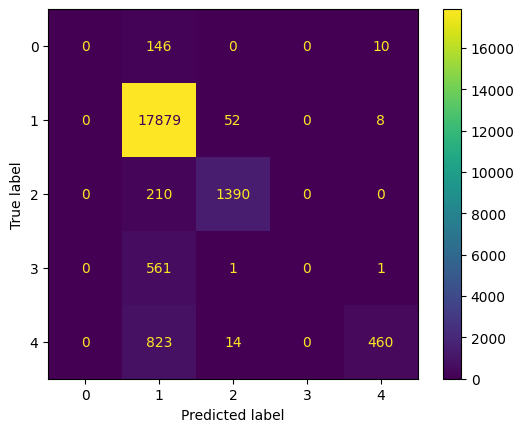

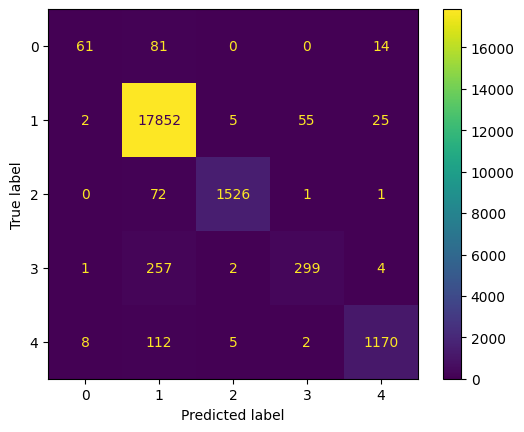

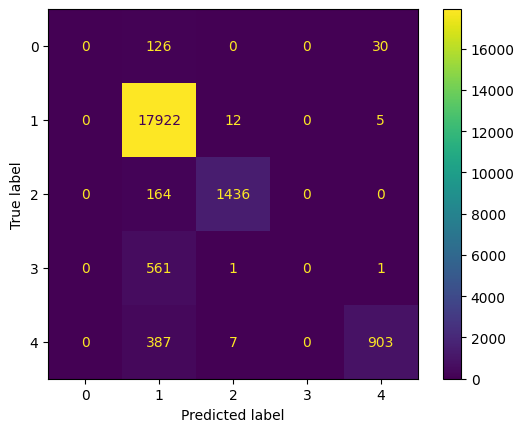

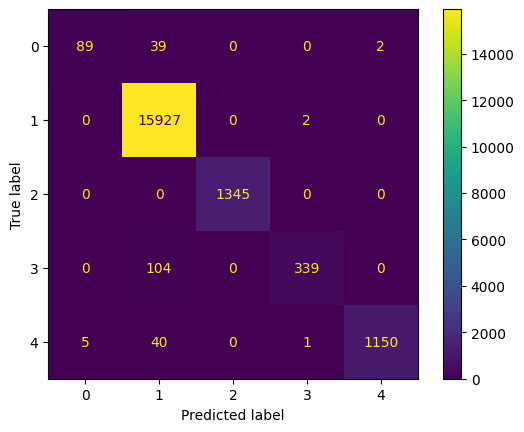

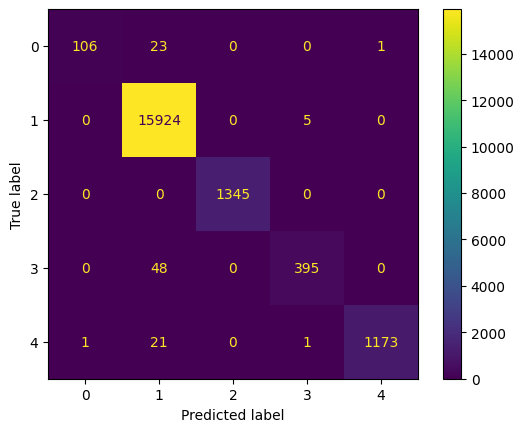

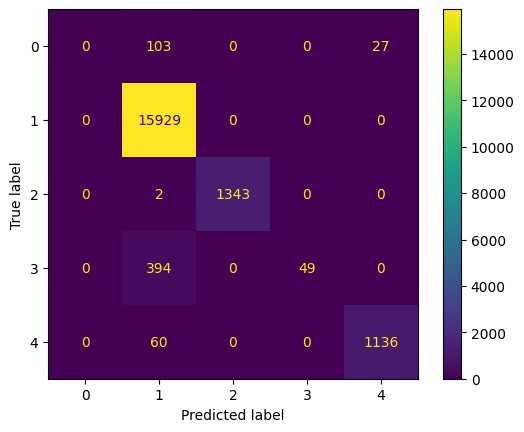

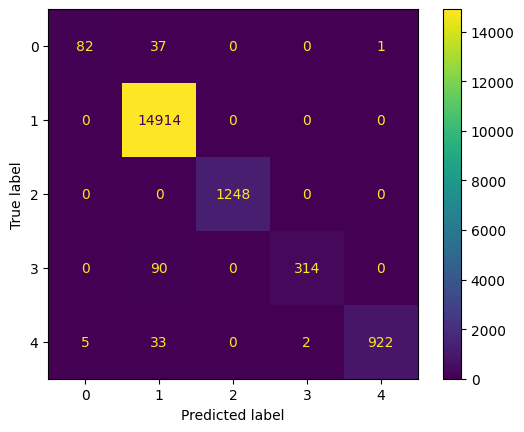

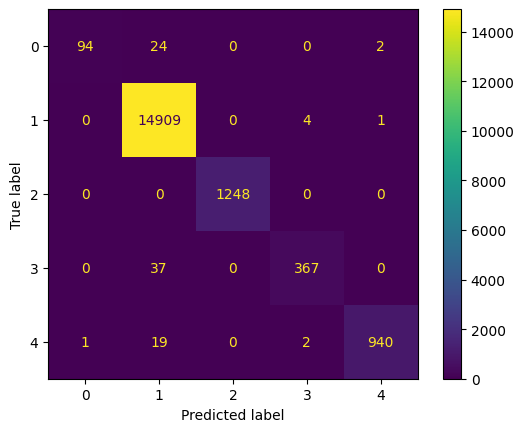

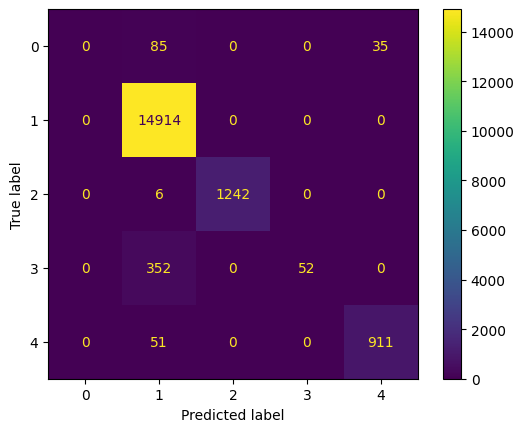

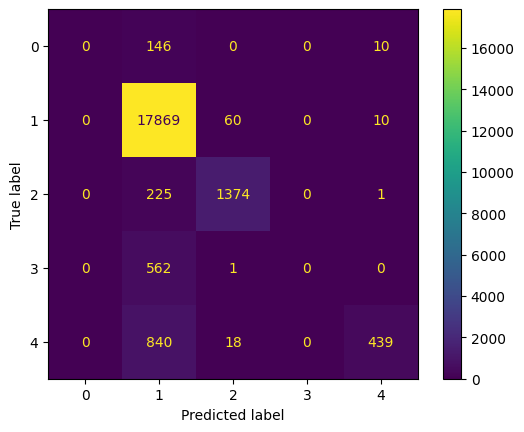

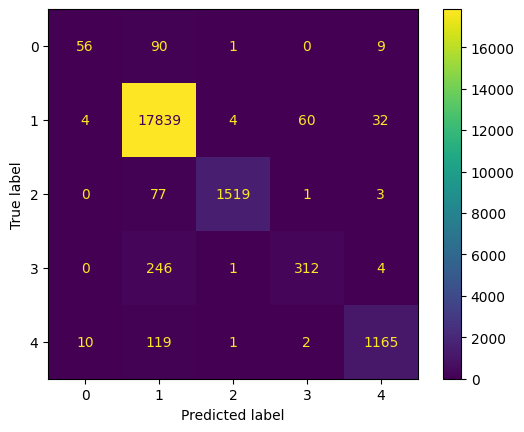

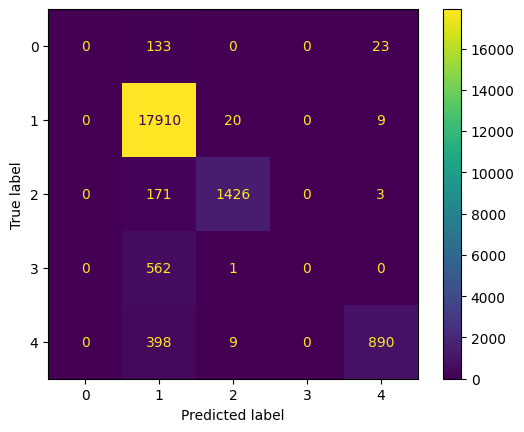

In [32]:
### run the model on all datasets
results_dict_global_svm = {}
results_dict_global_svm_cv = {}

for data, df in dict_with_all_dfs.items():
  print('\n****************',data, df.shape)
  x_train, y_train, x_val, y_val, x_test, y_test = train_test_val_split_func_updated( df )
  for kernel in kernels:
    results_list, result_list_cv = svm_model( x_train, y_train, x_val, y_val, x_test, y_test, kernel, data )
    results_dict_global_svm[ data + '#' + kernel ]    = results_list
    results_dict_global_svm_cv[ data + '#' + kernel ] = result_list_cv

In [33]:
#### RESULTS ON TEST DATA
df_final_svm = pd.DataFrame( data = results_dict_global_svm.values(), columns = results_columns_svm )
df_final_svm

,dataset,kernel,accuracy,specificity,sensitivity
0,df_full_norm,linear,0.92,0.90,0.44
1,df_full_norm,poly,0.97,0.97,0.75
2,df_full_norm,rbf,0.94,0.93,0.52
3,df_without_outliers_50_norm,linear,0.99,0.99,0.88
4,df_without_outliers_50_norm,poly,0.99,0.99,0.94
5,df_without_outliers_50_norm,rbf,0.97,0.96,0.61
6,df_without_outliers_60_norm,linear,0.99,0.99,0.88
7,df_without_outliers_60_norm,poly,0.99,0.99,0.93
8,df_without_outliers_60_norm,rbf,0.97,0.96,0.61
9,df_pca,linear,0.91,0.90,0.44


In [34]:
## RESULTS ON CV DATA
df_final_svm_cv = pd.DataFrame( data = results_dict_global_svm_cv.values(), columns = results_columns_svm_cv )
df_final_svm_cv

,dataset,kernel,mean,std
0,df_full_norm,linear,0.85,0.0
1,df_full_norm,poly,0.96,0.0
2,df_full_norm,rbf,0.92,0.0
3,df_without_outliers_50_norm,linear,0.98,0.0
4,df_without_outliers_50_norm,poly,0.99,0.0
5,df_without_outliers_50_norm,rbf,0.96,0.0
6,df_without_outliers_60_norm,linear,0.98,0.0
7,df_without_outliers_60_norm,poly,0.99,0.0
8,df_without_outliers_60_norm,rbf,0.96,0.0
9,df_pca,linear,0.86,0.0


# Deep Learning Model

#### 1.Feed Forward Neural Network

In [35]:
## import important libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# import torchmetrics

import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer

In [36]:
# ## define parameters
train_on_gpu = torch.cuda.is_available() ## it will return True or False

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is not available.  Training on CPU ...
cpu


In [37]:
# device = 'cuda'
learning_rate = 0.001
batch_size = 20
experiment_name = 'ECG_project'

In [59]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.input_cols = list(set(self.df.columns) - set(['y']))  # save cols
        self.output_cols = ['y']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cur_sample = self.df.iloc[idx]  # read row, split in input and output and convert in tensors

        cur_sample_x = cur_sample[self.input_cols]  # split in input / ground-truth
        cur_sample_y = cur_sample[self.output_cols]  # split in input / ground-truth

        cur_sample_x = torch.tensor(cur_sample_x.tolist(), dtype=torch.float32)  # convert the quantities into the tensor (torch format)
        cur_sample_y = torch.tensor(cur_sample_y.tolist(), dtype=torch.long).squeeze()  # convert the quantities into the tensor (torch format)

        return cur_sample_x, cur_sample_y

In [60]:
train = df_norm.iloc[ : int(len(df_norm) * 0.6) ].reset_index( drop = True )
valid = df_norm.iloc[ int(len(df_norm) * 0.6) : int(len(df_norm) * 0.8) ].reset_index( drop = True )
test  = df_norm.iloc[ int(len(df_norm) * 0.8) : ].reset_index( drop = True )

print(f'train shape = {train.shape}')
print(f'valid shape = {valid.shape}')
print(f'test  shape = {test.shape}')

train shape = (64665, 181)
valid shape = (21555, 181)
test  shape = (21555, 181)


In [61]:
train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,y
0,0.520405,0.526864,0.523670,0.519865,0.517617,0.510391,0.508530,0.508909,0.506956,0.509773,...,0.467338,0.476081,0.481996,0.484566,0.480239,0.476895,0.477356,0.481698,0.477061,1
1,0.520928,0.522149,0.525377,0.523295,0.519756,0.517284,0.520118,0.523029,0.523613,0.521019,...,0.471641,0.474447,0.479654,0.479635,0.477905,0.476201,0.477450,0.480144,0.476786,2
2,0.537857,0.541467,0.543386,0.540192,0.538609,0.537771,0.540151,0.542919,0.541039,0.540228,...,0.477996,0.482041,0.488410,0.489562,0.485555,0.483947,0.483476,0.485334,0.482326,1


In [62]:
train_ds = Dataset( train )
print( f'trainset length -- {train_ds.__len__()}')

val_ds =  Dataset( valid )
print( f'validset length -- {val_ds.__len__()}' )

test_ds = Dataset( test )
print( f'trainset length -- {test_ds.__len__()}\n')

xx,yy = test_ds.__getitem__(0) # get first item and print the shape of the tensor
print(xx.shape)
print(yy.shape)

trainset length -- 64665
validset length -- 21555
trainset length -- 21555

torch.Size([180])
torch.Size([])


In [63]:
# create train dataloader -- for parallel data loading
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size = batch_size,
    drop_last = True,
    shuffle = True,
    num_workers = 8
)
# create validation dataloader
val_dl = torch.utils.data.DataLoader(
    val_ds,
    batch_size = batch_size,
    # drop_last argument drops the last non-full batch of each worker’s iterable-style dataset
    drop_last = False,
    shuffle = False,
    # Setting the argument num_workers as a positive integer will turn on multi-process data loading
    # with the specified number of loader worker processes.
    num_workers = 8
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [64]:
## dataloaders
print(f'num of batches in train loader   = { int(train_ds.__len__() / batch_size) }\n') # drop_last = True
# print(f'last train loader has data items = { train_ds.__len__() % batch_size }\n')

print(f'num of batches in valid loader   = { int(val_ds.__len__()   / batch_size)+1 }') # drop_last = False
print(f'last valid loader has data items = { val_ds.__len__()   % batch_size }')

num of batches in train loader   = 3233

num of batches in valid loader   = 1078
last valid loader has data items = 15


In [65]:
## Check the data inside the data loader
for data in val_dl:
  inp, gt = data
  print(f'input shape -- {inp.shape}')
  print(f'gt shape    -- {gt.shape}')
  break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


input shape -- torch.Size([20, 180])
gt shape    -- torch.Size([20])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [66]:
num_of_features = xx.shape[0]
print(f'num_of_features = {num_of_features}, input layer will have {num_of_features} neurons')

num_of_features = 180, input layer will have 180 neurons


In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(num_of_features, 128)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.ReLU()
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.ReLU()
        self.layer7 = nn.Linear(32, 16)
        self.layer8 = nn.ReLU()
        self.layer9 = nn.Linear(16, 5)  # Changed from 1 to 5 for multi-class classification

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        return x

In [57]:
## let's test the network with fake input
net = Net()
net.to(device)           # let's move the network to device

inp_ = torch.rand(20, 93) # define random batch of 10 elements to test the network
inp_ = inp.to(device)     # move the batch in GPU
out_ = net(inp)           # get the output

# let's print the shape
print('Input shape is ', inp_.shape)
print('Output shape is', out_.shape)

Input shape is  torch.Size([20, 180])
Output shape is torch.Size([20, 5])


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Example model path and parameters
model_path = '/content/drive/My Drive/Advance_Comp/MIT-BIH.csv'
loss_func = nn.CrossEntropyLoss()  # Changed to CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(params=net.parameters(), lr=learning_rate)
writer = SummaryWriter(experiment_name)
n_iter = 0
best_val_score = None

def validate(model, val_loader):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class with the highest score
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    val_acc = running_corrects.double() / total
    return val_acc

for cur_epoch in range(1, 10):
    print(f'epoch = {cur_epoch},', end=" ")
    writer.add_scalar("epoch", cur_epoch, n_iter)
    counter = 0
    net.train()  # Ensure the model is in training mode
    for inp, gt in train_dl:
        counter += 1
        inp = inp.to(device)
        gt = gt.to(device)
        optimizer.zero_grad()
        out = net(inp)
        loss = loss_func(out, gt)
        loss.backward()
        optimizer.step()
        writer.add_scalar("loss", loss.item(), n_iter)
        n_iter += 1

    cur_val_score = validate(net, val_dl)
    writer.add_scalar("val", cur_val_score, n_iter)  # Corrected to plot validation score
    print(f'current validation score = {cur_val_score}')

    if best_val_score is None or cur_val_score > best_val_score:
        best_val_score = cur_val_score
        data = {
            'net': net.state_dict(),
            'opt': optimizer.state_dict(),
            'epoch': cur_epoch
        }
        torch.save(data, model_path + '_best.pth')

    data = {
        'net': net.state_dict(),
        'opt': optimizer.state_dict(),
        'epoch': cur_epoch
    }
    torch.save(data, model_path + '_last.pth')


epoch = 1, current validation score = 0.9624681048480631
epoch = 2, current validation score = 0.9502203665042913
epoch = 3, current validation score = 0.964834145209928
epoch = 4, current validation score = 0.963163999072141
epoch = 5, current validation score = 0.9642774298306658
epoch = 6, current validation score = 0.9639990721410345
epoch = 7, current validation score = 0.9659011830201809
epoch = 8, current validation score = 0.9578752029691487
epoch = 9, current validation score = 0.9694270470888425


In [71]:
cur_val_score

tensor(0.9694, dtype=torch.float64)

####Testing

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Create testing function
def testing_func(net, dl):
    predictions = []
    loss_func = nn.CrossEntropyLoss()

    score = 0  # Initialize score
    net.eval()  # Set network in eval mode
    i = 1  # Counter to check the batches
    for inp, gt in dl:  # Iterate over batches

        inp = inp.to(device)  # Move batch to GPU
        gt = gt.to(device).long()  # Move batch to GPU

        with torch.no_grad():  # Get output
            out = net(inp)

        # Get the predicted class indices
        _, preds = torch.max(out, 1)
        predictions.append(preds.cpu().numpy())

        # Calculate the loss
        cur_score = loss_func(out, gt)  # Compare with ground truth
        score += cur_score.item()  # Append to score

        i += 1

    score /= len(dl)  # Average over batches
    net.train()  # Set network back to training mode

    pred = [int(p) for preds_batch in predictions for p in preds_batch]

    return score, pred  # Return score and predictions

In [75]:
# Create dataloader
test_dl = torch.utils.data.DataLoader(
    test_ds,
    batch_size=batch_size,
    drop_last=False,
    shuffle=False,
    num_workers=8
)

# Load best network
state = torch.load(model_path + '_best.pth')
net.load_state_dict(state['net'])

test_score, pred = testing_func(net, test_dl)
print(f'The model scored a loss of {test_score:0.04f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


The model scored a loss of 0.1159


In [76]:
actual = [int(g) for inp, gt in test_dl for g in gt]

print(len(pred))
print(len(actual))

21555
21555


In [77]:
# Calculate test accuracy
accuracy_test = accuracy_score(actual, pred)
print(f'Accuracy: {accuracy_test}\n')

Accuracy: 0.96961261888193



In [78]:
# Compute confusion matrix
cm = confusion_matrix(actual, pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[   33   103     9     0    17]
 [    0 17839    16     7    13]
 [    1    48  1537     1     5]
 [    0   271    17   257     4]
 [   13   122     7     1  1234]]
